#### Imports

In [3]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

#### Scrape key to facility codes
- Very inclusive info about keys, many things not keys included

In [3]:
year = 1998

pdfFileObj = open('{0}/directory_{0}.pdf'.format(year), 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
print("Number of pages:", pdfReader.numPages)

Number of pages: 568


In [582]:
abbr_keys = ["TX", "ML", "PV", "OS", "DT",\
             "OD", "OR", "IO", "ID", "IR", "RD", "RR",\
             "AD", "DD", "HV", "PW",\
             "SS", "GH", "PH", "OH", "TC", "HH", "CM", "CH", \
             "CO", "SG", "SC", "CJ",\
             "MC", "MD", "FG", "PI"]

#### List of States in the U.S.

In [476]:
states = "Alabama,\
Alaska,\
Arizona,\
Arkansas,\
California,\
Colorado,\
Connecticut,\
Delaware,\
Florida,\
Georgia,\
Hawaii,\
Idaho,\
Illinois,\
Indiana,\
Iowa,\
Kansas,\
Kentucky,\
Louisiana,\
Maine,\
Maryland,\
Massachusetts,\
Michigan,\
Minnesota,\
Mississippi,\
Missouri,\
Montana,\
Nebraska,\
Nevada,\
New Hampshire,\
New Jersey,\
New Mexico,\
New York,\
North Carolina,\
North Dakota,\
Ohio,\
Oklahoma,\
Oregon,\
Pennsylvania,\
Rhode Island,\
South Carolina,\
South Dakota,\
Tennessee,\
Texas,\
Utah,\
Vermont,\
Virginia,\
Washington,\
West Virginia,\
Wisconsin,\
Wyoming"

In [477]:
states = states.split(",")

In [478]:
states

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

#### Test on a page of data
- data starts on page 12 (getPage(11))
- split to each city, then split into data centers, clean city name and keys!

- Function to match city names

In [888]:
def fuzzy_search(search_key, text):
    #print("Searching {}...".format(search_key))
    #print("in", text)
    l = len(search_key)
    search_key = search_key.lower()
    strictness = int(l/4) + 1
    for pos in re.finditer(r"[\.,]", text):
        word_to_test = text[pos.start() - l: pos.start()].lower()
        i = 0
        diff = 0
        while i < l:
            if word_to_test[i] != search_key[i]:
                diff += 1
            i += 1
        if diff < strictness:
            return (pos.start() - l, pos.start())      

In [889]:
#test
text = "DemopolisWestAl.abamaMentalDcmopolis.AL36732"
fuzzy_search("DEMOPOLIS", text)

(27, 36)

- Fucntion to split words

In [985]:
def split_cap_words(string):
    string = re.sub(r"([A-z()])([A-Z0-9])([a-z0-9])", r"\1 \2\3", string)
    string = re.sub(r"([0-9])([A-Za])", r"\1 \2", string) #keep 1st, 2nd, 3rd, 4th
    string = re.sub(r"([A-z])([0-9])", r"\1 \2", string)
    string = re.sub(r"([A-z])(of)( )", r"\1 \2\3", string)
    return  string#(\w)([A-Z])([a-z])

In [986]:
#test
split_cap_words("Ltghthouseof Tallapoosa County Inc")

'Ltghthouse of Tallapoosa County Inc'

In [987]:
split_cap_words("17136thAvenueSouth")

'17136th Avenue South'

In [988]:
split_cap_words("17132ndAvenueSouth")

'17132nd Avenue South'

In [989]:
split_cap_words("PGBHAPinalCountyHispanicCouncil712NorthMainStreet")

'PGBHA Pinal County Hispanic Council 712 North Main Street'

In [990]:
split_cap_words("CommunityCareNetwork(CCN)JewishFamilyandChildrensServices6376WestBellRoad")

'Community Care Network(CCN) Jewish Familyand Childrens Services 6376 West Bell Road'

In [991]:
split_cap_words("MohaveMentalHealthClinicOutpatientandDayTreatment2135Highway9SSuites125and241")

'Mohave Mental Health Clinic Outpatientand Day Treatment 2135 Highway 9 S Suites 125 and 241'

In [992]:
split_cap_words("564NorthIdahoRoadSuite9")

'564 North Idaho Road Suite 9'

- Split data into a list containing a list of facilities in that city

In [1057]:
def split_data(rawdata, firstcity):
    '''
    Roughly split data into each facility, returns list of list.
    '''
    
    data = []
    city = firstcity
    
    while len(rawdata) > 50:
        temp_city = []
        m = 1
        
        if rawdata[:3].isupper(): #find city name and delete from rawdata
            #find the capitalized string
            m = re.search("[A-Z]+", rawdata).end()
            city = rawdata[:m - 1]
            #print("Trying to find city...", city)
            #clean state name from the city name if present
            for state in states:
                if state.lower() in city.lower():
                    city = city[len(state):]
                    rawdata = rawdata[len(state):]
                    m = m - len(state)
            #identify city name
            if fuzzy_search(city, rawdata[m - 1:]) == None:
                i = 2
                while (i < m) and (fuzzy_search(rawdata[:i], rawdata[i:]) == None):
                    i += 1
                m = i + 1
                city = rawdata[:i]
        rawdata = rawdata[m - 1:]
        #####
        if fuzzy_search(city, rawdata) == None:
            m = re.search(r"[,\.]", rawdata).start()
            
            state = rawdata
        a, b = fuzzy_search(city, rawdata)
        state_clean = split_cap_words(rawdata[a:b])
        temp_city.append(state_clean)
        #####
        
        #while there is more facilities in this city (still can find city name in the string)
        #print("City name:", state_clean)
        while fuzzy_search(city, rawdata) != None:
            temp_facil = []
            a, b = fuzzy_search(city, rawdata)
            m = re.search("[A-Z]{2}[A-Z/][A-Z/]", rawdata[b:]).start() #start of the keys
            temp_facil.append(rawdata[:b+m])
            rawdata = rawdata[b+m:]
            temp_facil.append('')
            j = 0
            #append keys to the dataframe
            while (rawdata[j:j+2].replace("1", "I").replace("l", "I").replace("0", "O").replace("5", "S")\
                   .replace("i", "I") in abbr_keys) and (rawdata[j+2].replace("1", "I").replace("l", "I")\
            .replace("0", "O").replace("5", "S").replace("i", "I").isupper() or rawdata[j+2] == '/'):
                temp_facil[-1] += ' ' + \
                rawdata[j:j+2].replace("1", "I").replace("l", "I").replace("0", "O").replace("5", "S")
                if rawdata[j+2] == "/" or rawdata[j+2] == "J": #"/" is sometimes recognized as "J"
                    j += 3
                else:
                    j += 2
                    
            rawdata = rawdata[j:]
            temp_facil[-1] = temp_facil[-1].strip()
            temp_city.append(temp_facil)
            #print(temp_facil)
        print(temp_city)#####
        data.append(temp_city)
        i = 0
    
    while i < len(data):
        city = data[i]
        if not city[0][0].isupper():
            init = data[i - 1][-1][-1][-2:].capitalize()
            data[i - 1][-1][-1] = data[i - 1][-1][-1][:-3]
            data[i][0] = init + data[i][0]
        i += 1
    return data

In [1022]:
def split_center_street(cn_sa):
    '''
    Split a string containing center name and street address into two.
    Inputs:
        cn_sa(str)
    Returns: a list of two terms
    '''
    
    m = re.finditer(r"\d+", cn_sa)
    try:
        probe = next(m)
        span = probe.span()
        if span[1] == len(cn_sa):
            cn_sa = split_cap_words(cn_sa).split()
            return[' '.join(cn_sa[:-2]), ' '.join(cn_sa[-2:])]
        elif span[0] != 0:
            return ([split_cap_words(cn_sa[:span[0]]), split_cap_words(cn_sa[span[0]:])])
    except StopIteration:
        if cn_sa[-4:] == "Road":
            cn_sa = split_cap_words(cn_sa).split()
            return[' '.join(cn_sa[:-2]), ' '.join(cn_sa[-2:])]
    return [split_cap_words(cn_sa), '']


def split_address(csp):
    '''
    Split a string containing city, state and postal code.
    Inputs:
        csp(str): a string containing city, state and postal code
    Returns: a list of three items
    '''
    PASS

In [924]:
cn_sa = "SMMHCIncMentalHealthCtr/SubstAbuseServices564NorthIdahoRoadSuite9"
split_center_street(cn_sa)

['SMMHC Inc Mental Health Ctr/Subst Abuse Services',
 '564 North Idaho Road Suite 9']

In [925]:
cn_sa = "FortMcDowellIndianCommunityFamilyandCommunityServicesYavapaiRoad"
split_center_street(cn_sa)

['Fort McDowell Indian Community Familyand Community Services', 'Yavapai Road']

In [926]:
cn_sa = "VentressCorrectionalFacilitySubstanceAbuseServicesStateRoad239"
split_center_street(cn_sa)

['Ventress Correctional Facility Substance Abuse Services State', 'Road 239']

In [1038]:
def write_data(writer, data, year, pagen):
    '''
    Write data to csv
    '''
    for city in data:
        cityname = city[0]
        lencn = len(cityname.replace(' ', ''))
        for facil in city[1:]:
            data_holder = [year, pagen]
            keys = facil[1]
            facil = facil[0]
            #Center name
            if "," in facil:
                center_name_city, address = facil.split(",")
            else:
                center_name_city, address = facil.split(".")
            #City
            data_holder += split_center_street(center_name_city[:-lencn])
            #State
            data_holder.append(cityname)
            data_holder.append(address[:2])
            #Postal code, Phone
            if address[7] == "-":
                data_holder.append(address[2:12].replace("O", "0").replace("S", "5"))
                data_holder.append(address[12:].replace("O", "0").replace("S", "5"))
            else:
                data_holder.append(address[2:7].replace("O", "0").replace("S", "5"))
                data_holder.append(address[7:].replace("O", "0").replace("S", "5"))
            #Keys
            data_holder.append(keys)
            print(data_holder)
            writer.writerow(data_holder)
    print("Finished page {}".format(pagen))
    return data_holder[4]

In [1118]:
def run(year, start_page, end_page = 0):

    #read file
    dir_filename = '{0}/directory_{0}.pdf'.format(year)
    pdfFileObj = open(dir_filename, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    
    #pages to scrape
    if end_page == 0:
        end_page = pdfReader.numPages - 1

    save_as_filename = '{0}/{0}.csv'.format(year)
    if os.path.isfile(save_as_filename):
        with open(save_as_filename, 'a', newline='') as file:
            writer = csv.writer(file)
    else:
        with open(save_as_filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Year", "Page", "Center_name", "Street_address", "City", \
                             "State", "Postal_code", "Phone", "Keys"])
    #scrape
    firstcity = "Gridley"
    for pagen in range(start_page, end_page + 1):
        #print(pagen)
        rawdata = pdfReader.getPage(pagen - 1).extractText()
        
        data = split_data(rawdata, firstcity)
        
        with open(save_as_filename, 'a', newline='') as file:
            writer = csv.writer(file)
            firstcity = write_data(writer, data, year, pagen)

In [1119]:
run(1998, 42, 561) #12 15 24 25 31 32 33 34 35 42

['Gridley', ['HARBORCITYHEMETButteCountyBehavioralHealthGridleyFamilyCounselingCenter995SpruceStreetGridley,CA95948(530)891-2984Hotlines:(800)371-4373(800)334-6622', 'TX OS OR AD DD CM']]
['Grover Beach', ['CasaSolana383South13thStreetGroverBeach,CA93433(805)481-8555', 'TX PV RR SS FG']]
['Hanford', ['AlcoholandDrugEducationandCounselingCenter289East8thStreetHanford,CA93230(S59)582-4481', 'TX PV OS OR AD SS CJ PI'], ['CornerstoneCommAlc/DrugRecSystemsCornerstoneMensRecovery801-805West7thStreetHanford,CA93230(559)583-2033Hotline:(559)583-2034', 'TX OS DT RD RR SS'], ['CornerstoneRecoverySystemsWomensProgram817West7thStreetHanford,CA93230(559)583-2030Hotline:(559)583-2031', 'TX OS DT IO RD RR PW SS']]
['Happy Camp', ['RiverofWellnessandRecoveryofTheKarukTribalHealthProgram642362ndAvenueHappyCamp,CA96039(530)842-9200x00019', 'TX PV OS OR SS']]


TypeError: cannot unpack non-iterable NoneType object

In [1120]:
pagen = 42
rawdata = pdfReader.getPage(pagen - 1).extractText()
rawdata

'GRIDLEYHARBORCITYHEMETButteCountyBehavioralHealthGridleyFamilyCounselingCenter995SpruceStreetGridley,CA95948(530)891-2984Hotlines:(800)371-4373(800)334-6622TXOS/OR/ADDD/CMGROVERBEACHCasaSolana383South13thStreetGroverBeach,CA93433(805)481-8555TXPV/RR/SS/FGHANFORDAlcoholandDrugEducationandCounselingCenter289East8thStreetHanford,CA93230(S59)582-4481TXPVOS/OR/AD/SSCJ/PICornerstoneCommAlc/DrugRecSystemsCornerstoneMensRecovery801-805West7thStreetHanford,CA93230(559)583-2033Hotline:(559)583-2034TXOSDT/RDRR/SSCornerstoneRecoverySystemsWomensProgram817West7thStreetHanford,CA93230(559)583-2030Hotline:(559)583-2031TXOSDT/IORDRR/PW/SSHAPPYCAMPRiverofWellnessandRecoveryofTheKarukTribalHealthProgram642362ndAvenueHappyCamp,CA96039(530)842-9200x00019TXPVOS/OR/SSWesternHealthHarborCityClinic1647WestAnaheimStreetHarborCity,CA90710-3213(310)534-5590TXMLPVOSDT/ODORIO/DDPW/SSSG/MDPIHAWTHORNEBehavioralHealthServicesPacificaHouse2501WestElSegundoBoulevardHawthorne,CA90250(323)754-2816TXOS/RR/DDPW/SSTC/FGPIB

In [ ]:
rawdata = 'GARDENA
GILROYGOLETABehavioralHealthServicesOmniIS519CrenshawBoulevardGardena,CA90249(310)679-9031TXMLOSDT/ODOR/HVPW/SS/MDSpecialServicesforGroupsPacificAsianAlcoholandDrugProgram14112SouthKingslcyDriveGardena,CA90247(310)327-7501TXPV/ORIO/DDPW/SS
GARDENGROVE
CAHispanicCommissionAlc/DrugAbuseUnidosRecoveryHome9842West13thStreetSuiteBGardenGrove,CA92844(714)531-4624TXPVOSDT/RDRR/DDHV/SSRoqucCenterResidential9842West13thStreetSuiteAGardenGrove,CA92844(714)839-0607Hotlines:(714)839-0608(714)839-0609TXPVOS/RR/SS
GARDENVALLEY
ProgressHouseII5607MountMurphyRoadGardenValley,CA95633(916)333-9460Hotlines:(530)333-9460(888)S44-0900TXOS/RR/PW/SSTC/MDFGPI
GEORGETOWNElDoradoCouncilonAlcoholismLifeskills/DivideWellnessCenter606SHighway193Georgetown,CA95634(530)622-8193Hotline:(530)333-1917x0002TXPVOSDT/ODORIO/ADDDHV/SSCM/MCMDFGPl
GLENDALE
GlendaleMemorialHospital/HealthCtrAlphaRecoveryCenter1330SouthGlendaleAvenueGlendale,CA9120S(818)502-2300Hotlines:(818)502-2300(800)300-8040TXOSDT/ODORIOID/DD/SSGHCM/MCPI
NewInsightsSpecializedTreatmentforSubstAbuse431NorthBrandBoulevardSuite304Glendale,CA91203(818)242-2308TXPVOS/IO/SSRightOnPrograms522EastBroadwayStreetSuite101Glendale,CA91205(818)240-1683TXPVOS/OR/CJVerdugoMentalHealthCenterPositiveDirectionsComCounselingCtr225-DNorthMarylandAvenueGlendale,CA91206(818)247-8180TXPVOS/OR/SSCMVerdugoMentalHealthCenterSubstanceAbuseProgram1540EastColoradoStreetGlendale,CA91205-IS14(818)244-7257TXOS/OR/DDHV/SSCM
GLENDORA
ProjectInfoCommunityServicesIncIS05SouthSunflowerAvenueGlendora,CA91740(626)335-8153TXPVOS/OR/ADPW/SC
GILROY
CommunitySolutions8475ForestStreetGilroy,CA95020(408)842-7138Hotline:(800)488-9919TXPVOS/OR/ADDDHV/SSCMCOCJ/PI
GOLETA
AegisMedicalSystems5710HollisterAvenueGolcta,CA93117(805)681-7242TXMLOSDT/ODOR/SS/FG
IslaVistaHealthProjectsIslaVistaMedicalClinic970EmbarcaderoDelMarGoleta,CA93117(805)968-1511x110TXDT/ODOR/PW/CH/MD
GRANDTERRACE
DrugAlternativeProgram11810KingstonStreetGrandTerrace,CA92313(909)783-1094Hotlines:(909)783-1094(800)784-1094TX/RR/SS
GRASSVALLEY
NevadaCountyCouncilonAlcoholismNVCntySubAbuseTrtandRecProg440HendersonStreetSuiteCGrassValley,CA959450(530)273-9541Hotline:(530)273-9541TXPVOS/ORIO/AD/SS
TeamIIIFamilyCounselingCenter256BuenaVistaDriveSuite210GrassValley,CA95945(530)477-7025TXPVOS/OR/CM/MDPI
GREENBRAERossHospitalChemicalDependencyServicesIIIISirFrancisDrakeBoulevardGrecnbrae,CA94904(415)258-6960Hotline:(800)767-7677TXOSDT/ORIOIDIR/DDHV/SSPHOHCM/PICALIFORNIA30ForCodeDefinitions-SeeKEYonpagev.'

In [1115]:
rawdata = 'GARDENAGILROYGOLETABehavioralHealthServicesOmniIS519CrenshawBoulevardGardena,CA90249(310)679-9031TXMLOSDT/ODOR/HVPW/SS/MDSpecialServicesforGroupsPacificAsianAlcoholandDrugProgram14112SouthKingslcyDriveGardena,CA90247(310)327-7501TXPV/ORIO/DDPW/SSGARDENGROVECAHispanicCommissionAlc/DrugAbuseUnidosRecoveryHome9842West13thStreetSuiteBGardenGrove,CA92844(714)531-4624TXPVOSDT/RDRR/DDHV/SSRoqucCenterResidential9842West13thStreetSuiteAGardenGrove,CA92844(714)839-0607Hotlines:(714)839-0608(714)839-0609TXPVOS/RR/SSGARDENVALLEYProgressHouseII5607MountMurphyRoadGardenValley,CA95633(916)333-9460Hotlines:(530)333-9460(888)S44-0900TXOS/RR/PW/SSTC/MDFGPIGEORGETOWNElDoradoCouncilonAlcoholismLifeskills/DivideWellnessCenter606SHighway193Georgetown,CA95634(530)622-8193Hotline:(530)333-1917x0002TXPVOSDT/ODORIO/ADDDHV/SSCM/MCMDFGPlGLENDALEGlendaleMemorialHospital/HealthCtrAlphaRecoveryCenter1330SouthGlendaleAvenueGlendale,CA9120S(818)502-2300Hotlines:(818)502-2300(800)300-8040TXOSDT/ODORIOID/DD/SSGHCM/MCPINewInsightsSpecializedTreatmentforSubstAbuse431NorthBrandBoulevardSuite304Glendale,CA91203(818)242-2308TXPVOS/IO/SSRightOnPrograms522EastBroadwayStreetSuite101Glendale,CA91205(818)240-1683TXPVOS/OR/CJVerdugoMentalHealthCenterPositiveDirectionsComCounselingCtr225-DNorthMarylandAvenueGlendale,CA91206(818)247-8180TXPVOS/OR/SSCMVerdugoMentalHealthCenterSubstanceAbuseProgram1540EastColoradoStreetGlendale,CA91205-IS14(818)244-7257TXOS/OR/DDHV/SSCMGLENDORAProjectInfoCommunityServicesIncIS05SouthSunflowerAvenueGlendora,CA91740(626)335-8153TXPVOS/OR/ADPW/SCGILROYCommunitySolutions8475ForestStreetGilroy,CA95020(408)842-7138Hotline:(800)488-9919TXPVOS/OR/ADDDHV/SSCMCOCJ/PIGOLETAAegisMedicalSystems5710HollisterAvenueGolcta,CA93117(805)681-7242TXMLOSDT/ODOR/SS/FGIslaVistaHealthProjectsIslaVistaMedicalClinic970EmbarcaderoDelMarGoleta,CA93117(805)968-1511x110TXDT/ODOR/PW/CH/MDGRANDTERRACEDrugAlternativeProgram11810KingstonStreetGrandTerrace,CA92313(909)783-1094Hotlines:(909)783-1094(800)784-1094TX/RR/SSGRASSVALLEYNevadaCountyCouncilonAlcoholismNVCntySubAbuseTrtandRecProg440HendersonStreetSuiteCGrassValley,CA959450(530)273-9541Hotline:(530)273-9541TXPVOS/ORIO/AD/SSTeamIIIFamilyCounselingCenter256BuenaVistaDriveSuite210GrassValley,CA95945(530)477-7025TXPVOS/OR/CM/MDPIGREENBRAERossHospitalChemicalDependencyServicesIIIISirFrancisDrakeBoulevardGrecnbrae,CA94904(415)258-6960Hotline:(800)767-7677TXOSDT/ORIOIDIR/DDHV/SSPHOHCM/PICALIFORNIA30ForCodeDefinitions-SeeKEYonpagev.'

In [1116]:
data = split_data(rawdata, "Coloma")
data

['Gardena', ['GILROYGOLETABehavioralHealthServicesOmniIS519CrenshawBoulevardGardena,CA90249(310)679-9031', 'TX ML OS DT OD OR HV PW SS MD'], ['SpecialServicesforGroupsPacificAsianAlcoholandDrugProgram14112SouthKingslcyDriveGardena,CA90247(310)327-7501', 'TX PV OR IO DD PW SS']]
['Garden Grove', ['CAHispanicCommissionAlc/DrugAbuseUnidosRecoveryHome9842West13thStreetSuiteBGardenGrove,CA92844(714)531-4624', 'TX PV OS DT RD RR DD HV SS'], ['RoqucCenterResidential9842West13thStreetSuiteAGardenGrove,CA92844(714)839-0607Hotlines:(714)839-0608(714)839-0609', 'TX PV OS RR SS']]
['Garden Valley', ['ProgressHouseII5607MountMurphyRoadGardenValley,CA95633(916)333-9460Hotlines:(530)333-9460(888)S44-0900', 'TX OS RR PW SS TC MD FG PI']]
['Georgetown', ['ElDoradoCouncilonAlcoholismLifeskills/DivideWellnessCenter606SHighway193Georgetown,CA95634(530)622-8193Hotline:(530)333-1917x0002', 'TX PV OS DT OD OR IO AD DD HV SS CM MC MD FG PI']]
['Glendale', ['GlendaleMemorialHospital/HealthCtrAlphaRecoveryCente

[['Gardena',
  ['GILROYGOLETABehavioralHealthServicesOmniIS519CrenshawBoulevardGardena,CA90249(310)679-9031',
   'TX ML OS DT OD OR HV PW SS MD'],
  ['SpecialServicesforGroupsPacificAsianAlcoholandDrugProgram14112SouthKingslcyDriveGardena,CA90247(310)327-7501',
   'TX PV OR IO DD PW SS']],
 ['Garden Grove',
  ['CAHispanicCommissionAlc/DrugAbuseUnidosRecoveryHome9842West13thStreetSuiteBGardenGrove,CA92844(714)531-4624',
   'TX PV OS DT RD RR DD HV SS'],
  ['RoqucCenterResidential9842West13thStreetSuiteAGardenGrove,CA92844(714)839-0607Hotlines:(714)839-0608(714)839-0609',
   'TX PV OS RR SS']],
 ['Garden Valley',
  ['ProgressHouseII5607MountMurphyRoadGardenValley,CA95633(916)333-9460Hotlines:(530)333-9460(888)S44-0900',
   'TX OS RR PW SS TC MD FG PI']],
 ['Georgetown',
  ['ElDoradoCouncilonAlcoholismLifeskills/DivideWellnessCenter606SHighway193Georgetown,CA95634(530)622-8193Hotline:(530)333-1917x0002',
   'TX PV OS DT OD OR IO AD DD HV SS CM MC MD FG PI']],
 ['Glendale',
  ['GlendaleMem

In [1109]:
data = [['Coloma',
  ['ProgressHouseIncorporatedMensFacility838BeachCourtRoadColoma,CA95613(530)626-7252',
   'TX OS RR DD SS TC FG PI']],
 ['Colton',
  ['WesternClinicalHealthServsWCHSInlandHealthServicesIHS/Colton2275EastCooleyDriveColton,CA92324-6324(909)370-1777',
   'TX ML OS DT OD OR SS MD CO']],
 ['Colusa',
  ['LUSAColusaCountyBehavioralHealthServices85EastWebsterStreetColusa,CA95932(530)458-0520','TX PV OS OR IO AD SS']],
 ['Compton',
  ['COMPTONCityofComptonSpecialServicesCenter404NorthAlamedaStreetCompton,CA90221(310)605-5693',
   'TX PV OS DT OD OR IO AD PW SS OH CJ'],
  ['GetOffDrugsTreatmentCenterWomensHome1416SouthTamarindStreetCompton,CA90220(310)635-9740',
   'TX PV OS DT RD RR HV SS TC'],
  ['KaziHouseResidentialDrugProgram930WestComptonBoulevardCompton,CA90220(310)639-6393',
   'TX OS RR DD HV PW SS TC'],
  ['King/DrewSubstanceAbuseTrtProgram3221NorthAlamedaStreetBuilding4SuiteJCompton,CA90222(310)631-5992',
   'TX PV OS OR IO SS'],
  ['MiniTwelveStepHouseTheSolutionDropInCenter200NorthLongBeachBoulevardCompton,CA90221(310)608-1505Hotline:(800)262-2463',
   'TX PV OS OR IO SS CJ'],
  ['ShieldsforFamiliesExodus1500EastKayStreetCompton,CA90221(310)603-2654',
   'TX OS IO RR HV PW SS MD']],
 ['Concord',
  ['AffordableDetox2481PachecoStreetConcord,CA94520-2019(925)680-8933',
   'PV DT OD OR SS SG'],
  ['BiBettCorporationFredericOzanamCenter2931ProspectStreetConcord,CA94518(925)676-4840',
   'TX RR SS FG'],
  ['BiBettCorporationShcnnumCenter2090CommerceAvenueConcord,CA94520(925)676-2580',
   'TX PV OS DT RD SS'],
  ['MountDiabloMedicalPavilionCenterforRecovery2740GrantStreetConcord,CA94520(925)674-4160',
   'TX PV OS DT OD OR IO ID IR DD PH'],
  ['NewConnectionsTheKellerHouse1760ClaytonRoadConcord,CA94520(925)676-1601x30Hotlines:(800)846-1652(925)472-0999',
   'TX PV OS OR AD DD HV SS PI'],
  ['NewLeafTreatmentCenter2151SalvioStreetSuiteTConcord,CA94520-2458(925)688-0500Hotline:(800)846-1652',
   'TX PV OS DT OD OR IO DD SS MC MD PI'],
  ['RecoveryManagementServicesCrossroadsRecoveryCenterII2480PachecoStreetConcord,CA94520(925)682-5704',
   'TX OS RR DD SS'],
  ['RecoveryManagementServicesCrossroadsRecoveryCenterIII2118EastStreetConcord,CA94520(925)682-5704',
   'TX PV OS DT OD RR DD SS PI'],
  ['RecoveryManagementScrvtcesCrossroadsRecoveryCenterIV2080EastStreetConcord,CA94S20(925)682-5704',
   'TX PV OS DT OD RR DD SS PI'],
  ['RecoveryManagementServicesCrossroadsTreatmentCenterI2449PachecoStreet2ndHoorConcord,CA94520(925)682-5704',
   'TX PV OS DT OD OR IO RR DD SS PI'],
  ['SunriseHouse135MasonCircleUnitMConcord,CA94520(925)825-7049',
   'TX OS IO RR SS PI']],
 ['Corning',
  ['TchamaRecoveryCenterRightRoad275SolanoStreetCorning,CA96021(916)824-0669',
   'TX OS DT RD RR DD HV PW SS FG']]]

In [1117]:
save_as_filename = '{0}/{0}.csv'.format(year)

with open(save_as_filename, 'a', newline='') as file:
    writer = csv.writer(file)
    city = write_data(writer, data, year, pagen)

[1998, 41, 'GILROYGOLETA Behavioral Health Services OmniIS', '519 Crenshaw Boulevard', 'Gardena', 'CA', '90249', '(310)679-9031', 'TX ML OS DT OD OR HV PW SS MD']
[1998, 41, 'Special Servicesfor Groups Pacific Asian Alcoholand Drug Program', '14112 South Kingslcy Drive', 'Gardena', 'CA', '90247', '(310)327-7501', 'TX PV OR IO DD PW SS']
[1998, 41, 'CA Hispanic Commission Alc/Drug Abuse Unidos Recovery Home', '9842 West 13th Street SuiteB', 'Garden Grove', 'CA', '92844', '(714)531-4624', 'TX PV OS DT RD RR DD HV SS']
[1998, 41, 'Roquc Center Residential', '9842 West 13th Street SuiteA', 'Garden Grove', 'CA', '92844', '(714)839-0607Hotlines:(714)839-0608(714)839-0609', 'TX PV OS RR SS']
[1998, 41, 'Progress HouseII', '5607 Mount Murphy Road', 'Garden Valley', 'CA', '95633', '(916)333-9460Hotlines:(530)333-9460(888)544-0900', 'TX OS RR PW SS TC MD FG PI']
[1998, 41, 'El Dorado Councilon Alcoholism Lifeskills/Divide Wellness Center', '606 S Highway 193', 'Georgetown', 'CA', '95634', '(530)

- Check each term that has something blanck

In [23]:
from tika import parser
raw = parser.from_file('1998/test.pdf')
raw['content']

2020-07-10 14:58:45,902 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/c3/7w8m72ms5r1cjggp8xw9p0fh0000gn/T/tika-server.jar.md5.
2020-07-10 14:58:46,426 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/c3/7w8m72ms5r1cjggp8xw9p0fh0000gn/T/tika-server.jar.
2020-07-10 15:00:10,570 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2020-07-10 15:00:15,574 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2020-07-10 15:00:20,578 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2020-07-10 15:00:25,580 [MainThread  ] [ERROR]  Tika startup log message not received after 3 tries.
2020-07-10 15:00:25,581 [MainThread  ] [ERROR]  Failed to receive startup confirmation from startServer.


RuntimeError: Unable to start Tika server.

In [16]:
pdfFileObj = open('1998/test.pdf'.format(year), 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
print("Number of pages:", pdfReader.numPages)

Number of pages: 4


In [17]:
pdfReader.getPage(0).extractText()

'\n\n\n\n\n\n'

In [ ]:
#https://stackoverflow.com/questions/56559850/python-how-to-use-tika-with-existing-jar-file-without-downloading-again
#https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file
#https://opensource.google/projects/tesseract

# OCR
- https://github.com/sirfz/tesserocr
- https://www.geeksforgeeks.org/python-reading-contents-of-pdf-using-ocr-optical-character-recognition/
- https://pypi.org/project/tesserocr/

In [34]:
from tesserocr import PyTessBaseAPI, RIL
from pdf2image import convert_from_path 
import pytesseract
from PIL import Image 

In [14]:
import matplotlib.pyplot as plt

In [11]:
PDF_file = "1998/directory_1998.pdf"

In [23]:
# Store all the pages of the PDF in a variable 
pages = convert_from_path(PDF_file, 500) 

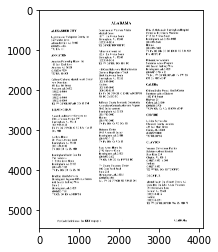

In [24]:
plt.imshow(pages[11])

In [30]:
pages[11].save("1998/page12.jpeg", 'JPEG') 
img = Image.open("1998/page12.jpeg")

In [40]:
boxes[1]

(<PIL.JpegImagePlugin.JpegImageFile image mode=L size=3427x75 at 0x7FA76EF1AC50>,
 {'x': 305, 'y': 473, 'w': 3427, 'h': 75},
 1,
 None)

In [54]:
box1 = {'x': 0, 'y': 0, 'w': 1400, 'h': 5143}
box2 = {'x': 1400, 'y': 0, 'w': 1200, 'h': 5143}
box3 = {'x': 2600, 'y': 0, 'w': 1400, 'h': 5143} #'w': 1400
boxes = [box1, box2, box3]

In [55]:
with PyTessBaseAPI() as api:
    api.SetImageFile("1998/page12.jpeg")
    #boxes = api.GetComponentImages(RIL.TEXTLINE, True)###
    print('Found {} textline image components.'.format(len(boxes)))
    #print(api.GetUTF8Text())
    #print(api.AllWordConfidences())
    for i, box in enumerate(boxes):
        # im is a PIL image object
        # box is a dict with x, y, w and h keys
        api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
        ocrResult = api.GetUTF8Text()
        conf = api.MeanTextConf()
        print('------------------------------')
        print(ocrResult)

Found 3 textline image components.
------------------------------
ALEXANDER CITY

L1 ghthouse of Tallapoosa County Inc
36 Franklin Street

Alexander City, AL 35010
(205)234-4894

TX/ RR! HH

ANNISTON

Anniston Fellowship House Inc
106 East 22nd Street

Anniston, AL 36201
(256)236-7229

TX/ RR/ HH CJ

Calhoun/Clebumc Mental Health Center
New Directions

331 East 8th Street

Anniston, AL 36202

(256)236-3403

Hotlines:

(256)236-3403

(256)236-8003

TX PV 05/ OR 10/ AD DD/ SS CM

BIRMINGHAM

Alcoholism Recovery Services Inc

2701 Jefferson Avenue SW
Birmingham, AL 3521 1

(205)923-6552

TX PV OS DT/ OR 10 RD RR/ HV/ SS
OH/ MD

Aletheia House
201 Finley Avenue West
Birmingham, AL 35204
(205)324-6502
TX 08/ OR 10/ 88/ MD

Birmingham Health Care for
The Homeless

712 25th Street North
Birmingham. AL 35203
(205 )439-72 1 6

TX PV 08/ OR 10/ 88/ FG

Bradford Health Services

Birmingham Regional Office Jefferson
631 Beacon Parkway West

Suite 21]

Birmingham, AL 35209
(800)293-7191

TX 08/ OR 